In [3]:
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

import rasterstats as rs
import xarray as xr
import rioxarray #for raster data
from rasterio.crs import CRS

/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [4]:
def lidar_val(lid_path, csv_path, snowdepth_col, lat_col, lon_col, csv_EPSG = 4326, zone_utmcrs= 32611, buffer = 3, lid_unit = "m", probe_unit = "m"):
    
    #read the lidar raster data
    lidar = rioxarray.open_rasterio(lid_path, masked = True)
    
    #reproject to crs of the zone
    if lidar.rio.crs.to_string() != "EPSG:" + str(zone_utmcrs):
        lidar = lidar.rio.reproject(CRS.from_string("EPSG:" + str(zone_utmcrs)))

    #read the csv
    df = pd.read_csv( csv_path, usecols=[snowdepth_col, lat_col, lon_col])

    #convert to geodataframe
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:" + str(csv_EPSG)
    )

    #convert the gdf to crs of the zone
    gdf_utm = gdf.to_crs("EPSG:" + str(zone_utmcrs))

    #Create buffer
    gdf_utm['buffer'] = gdf_utm.buffer(buffer)

    #drop columns and rename
    gdf_utm = gdf_utm.drop([lon_col, lat_col, 'geometry'], axis =  1).rename(columns = {'buffer' : 'geometry'})

    #calculate zonal statistics
    lidar_probe = rs.zonal_stats(gdf_utm, lidar.squeeze().values, nodata = -9999, geojson_out = True, 
                                    affine = lidar.rio.transform(), stats = "count mean std")

    #convert to geodataframe
    lidar_probe =  gpd.GeoDataFrame.from_features(lidar_probe)

    #convert the unit to m
    if probe_unit == "cm":
        lidar_probe[snowdepth_col] = lidar_probe[snowdepth_col] /100
    if lid_unit == "cm":
        lidar_probe["mean"] = lidar_probe["mean"]/100

    lidar_probe.rename(columns= {snowdepth_col : 'probed snow depth', 'mean' : 'lidar snow depth'}, inplace = True)
 
    fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
    sns.set(font_scale=2)
    ax = sns.regplot(x= lidar_probe["probed snow depth"], y=lidar_probe["lidar snow depth"])
    ax.errorbar(lidar_probe["probed snow depth"], lidar_probe["lidar snow depth"], yerr=lidar_probe["std"], fmt='none', capsize=2, zorder=1, color='C0')
    r = lidar_probe["probed snow depth"].corr(lidar_probe["lidar snow depth"])
    plt.legend(labels=[f"r: {r:.2f}"])
    plt.show()

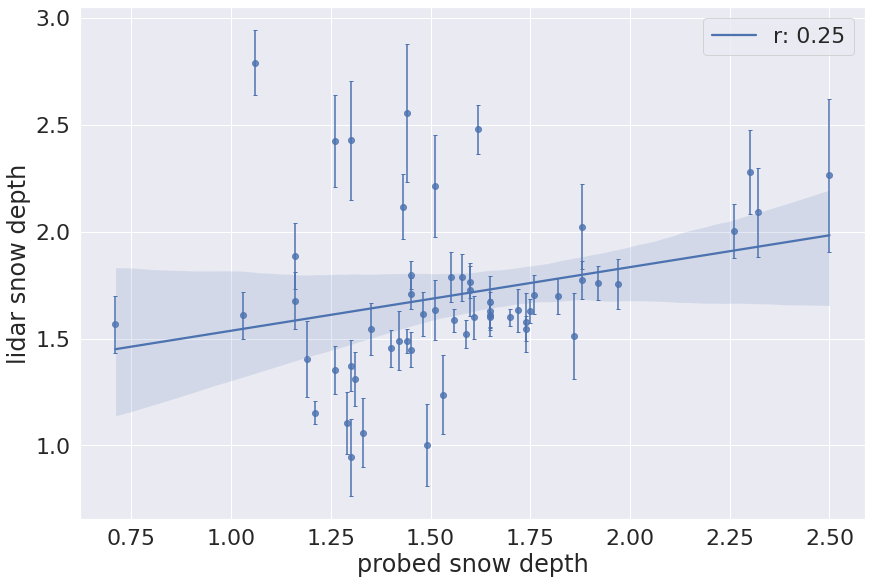

In [6]:
lidar_path = "/home/naheemadebisi/PhD/snow-analytics/lidar/helipod_data/results/MCS/20220317_MCS-snowdepth.tif"
csv_path = "/home/naheemadebisi/PhD/snow-analytics/lidar/helipod_data/results/MCS/files/3-17_PilotsPeak_ppk_pos_PROCESSED.csv"
lidar_val(lidar_path, csv_path, "Description", "Lat", "Lon", probe_unit = "cm")

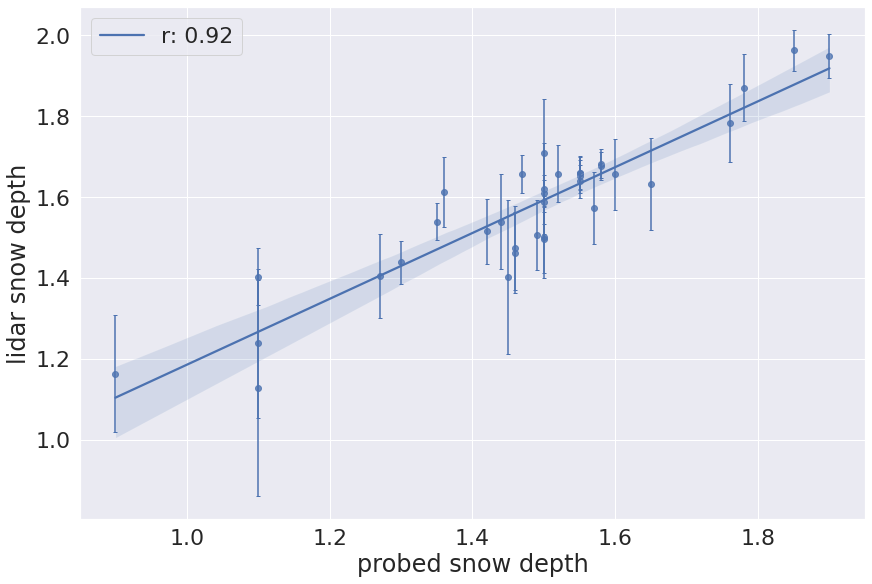

In [7]:
lidar_path = "/home/naheemadebisi/PhD/snow-analytics/lidar/helipod_data/results/MCS/20220407_MCS-snowdepth.tif"
csv_path = "/home/naheemadebisi/PhD/snow-analytics/lidar/helipod_data/results/MCS/files/4-7-22_pilot_ppk_pos_PROCESSED.csv"
lidar_val(lidar_path, csv_path, "Description", "Lat", "Lon", probe_unit = "cm")

I try on the feb17 probe file

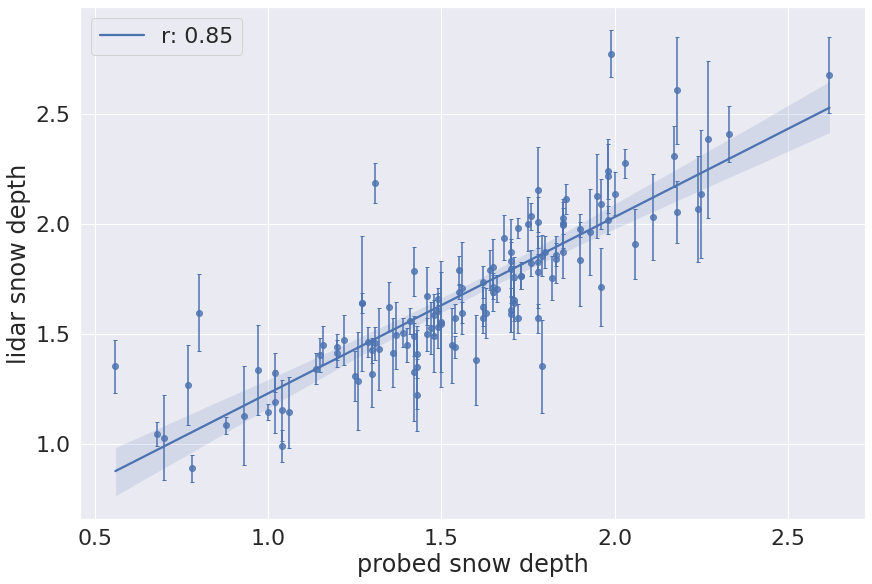

In [8]:
lidar_path = "/home/naheemadebisi/PhD/snow-analytics/lidar/helipod_data/results/MCS/20220217_MCS-snowdepth.tif"
csv_path = "/home/naheemadebisi/PhD/snow-analytics/lidar/helipod_data/results/MCS/files/Mcs17feb.csv"
lidar_val(lidar_path, csv_path, "Depth", "Latitude", "Longitude", probe_unit = "cm")